# House Prices - Regression Predictions YData 2024    

**Team: Random Forest Rangers** ([Dmitry Gufranov](https://www.linkedin.com/in/gufranov/), [Evgenia Amineva](https://www.linkedin.com/in/janeami/), [Valeriya Vazhnova](https://www.linkedin.com/in/gufranov/))

### Import libraries

In [53]:
import pandas as pd 
import numpy as np 
import datetime

# vizualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ml
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,  RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [54]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Loading the data

In [55]:
# load the train data
df = pd.read_csv('train.csv')
display(df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillMissTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        df_upd = X.copy()

        if 'LotFrontage' in df_upd.columns:
            self.nb_lot = df_upd.groupby('Neighborhood')['LotFrontage'].mean()
        
        return self
    
    def fill_lot(self, x):
        if pd.notnull(x['LotFrontage']):
            return x['LotFrontage']
        else:
            return self.nb_lot.loc[x['Neighborhood']]

    def transform(self, X):
        df_upd = X.copy()

        # Fill columns where missing values have a meaning 'NA'
        feat_wn = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
           'BsmtFinType1', 'BsmtCond', 'BsmtQual']
        
        for c in feat_wn:
            df_upd[c].fillna('NA', inplace=True)

        # Fill columns where missing values have a meaning '0'
        feat_w0 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
           'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea']   #'GarageYrBlt'

        for c in feat_w0:
            df_upd[c].fillna(0, inplace=True)

        # Fill 'LotFrontage' with mean values grouped by 'Neighborhood'
        if 'LotFrontage' in df_upd.columns:
            df_upd['LotFrontage'] = df_upd.apply(self.fill_lot, axis=1)
            # df_upd['LotFrontage'] = df_upd.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
   

        # Fill missing numeric features with mean values
        num_si = SimpleImputer(strategy='mean')
        num_col = df_upd.select_dtypes(include=['int', 'float']).columns
        df_upd[num_col] = num_si.fit_transform(df_upd[num_col])

        # Fill missing categorical features with most frequent values
        cat_si = SimpleImputer(strategy='most_frequent')
        cat_col = df_upd.select_dtypes(include=['object']).columns
        df_upd[cat_col] = cat_si.fit_transform(df_upd[cat_col])

        return df_upd

In [57]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_tdrop, num_cols_flag, rem_id):
        self.num_cols_tdrop = num_cols_tdrop
        self.num_cols_flag = num_cols_flag
        self.rem_id = rem_id
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        df_upd = X.copy()

        if 'OverallQual' in df_upd.columns and 'Neighborhood' in df_upd.columns:
            self.nb_qual = df_upd.groupby('Neighborhood')['OverallQual'].mean()

        return self
    
    def fill_nbgh(self, x):
        return self.nb_qual.loc[x['Neighborhood']]

    def transform(self, X):
        df_upd = X.copy()

        #Remove outliers
        df_upd = df_upd[~df_upd['Id'].isin(self.rem_id)]

        # Create new feature for bathrooms
        #df_upd['Bath'] = 0.225 * df_upd['BsmtFullBath'] + (-0.0121) * df_upd['BsmtHalfBath'] + 0.636 * df_upd['FullBath'] + 0.343 * df_upd['HalfBath']
        df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']
        #df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')
        df_upd['Neighborhoodqual'] = df_upd.apply(self.fill_nbgh, axis=1)

        # Drop columns
        df_upd = df_upd.drop(self.num_cols_tdrop, axis=1)

        # Flag transformation for numeric columns
        for c in self.num_cols_flag:
            if c in df_upd.columns:
                df_upd[c] = df_upd[c].apply(lambda x: 1 if x > 0 else 0)

        return df_upd

In [58]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols_oh, cat_cols_oe, cat_cols_tdrop):
        self.cat_cols_oh = cat_cols_oh
        self.cat_cols_oe = cat_cols_oe
        self.cat_cols_tdrop = cat_cols_tdrop
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Merge values in LotConfig
        if 'LotConfig' in df_upd.columns:
            df_upd.loc[df_upd['LotConfig']=='FR3', 'LotConfig'] = 'FR2'

        # Merge values in LandSlope
        if 'LandSlope' in df_upd.columns:
            df_upd.loc[df_upd['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
            df_upd['GtlSlope'] = df_upd['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)

        # Merge values in Condition1
        for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
            df_upd.loc[df_upd['Condition1']==cc[0], 'Condition1'] = cc[1]

        # Ordinal Encoding
        #oec = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]) 
        oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']])     #better
        # oec = OrdinalEncoder(categories = [['Po', 'NA', 'Fa', 'TA', 'Gd', 'Ex']])     #the best or not
        for cc in self.cat_cols_oe:
            if cc in df_upd.columns:
                df_upd[cc] = oec.fit_transform(df_upd[[cc]])

        return df_upd.drop(self.cat_cols_tdrop, axis=1)

In [59]:
# class NormalizationTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, num_cols_norm):
#         self.num_cols_norm = num_cols_norm
    
#     def fit(self, X, y=None):
#         # No need to fit anything for this transformer
#         return self
    
#     def transform(self, X):
#         df_upd = X.copy()

#         # Normalizing
#         power = PowerTransformer(method='yeo-johnson', standardize=True)
#         df_upd[self.num_cols_norm] = power.fit_transform(df_upd[self.num_cols_norm])

#         return df_upd

class NormalizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols_norm):
        self.num_cols_norm = num_cols_norm
        self.power = PowerTransformer(method='yeo-johnson', standardize=True)
    
    def fit(self, X, y=None):
        df_upd = X.copy()
        self.power.fit(df_upd[self.num_cols_norm])
        return self
    
    def transform(self, X):
        df_upd = X.copy()

        # Normalizing
        df_upd[self.num_cols_norm] = self.power.transform(df_upd[self.num_cols_norm])
        return df_upd

class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # No need to fit anything for this transformer
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(X, columns=self.columns, dtype='int')

## Preprocessing 

In [60]:
# for linear models

cat_cols_oe = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

cat_cols_oh = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', \
               'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', \
                'SaleCondition', 'MSSubClass', 'OverallCond', 'KitchenAbvGr', 'MoSold', 'YrSold']

cat_cols_tdrop = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature', 'MiscVal']

num_cols_norm = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', \
                 '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Totalarea'] #'GrLivArea', 

num_cols_asis = ['OverallQual', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

num_cols_tdrop = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'] #'1stFlrSF', '2ndFlrSF'

num_cols_flag = ['BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


#outliers
rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329]

ifeatures = ['1stFlrSF', '2ndFlrSF', 'LotArea', 'TotalBsmtSF', 'OpenPorchSF',
       'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'OverallQual', 'YearBuilt',
       'LotFrontage', 'BsmtUnfSF', 'GarageYrBlt', 'MasVnrArea', #'Bath',
       'WoodDeckSF', 'EnclosedPorch', 'CentralAir_N', 'HeatingQC',
       'KitchenQual', 'OverallCond_5.0', 'SaleCondition_Normal', 'FireplaceQu',
       'GarageCars', 'OverallCond_3.0', 'OverallCond_4.0', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'SaleCondition_Abnorml', 'MSZoning_RL',
       'Functional_Typ', 'BsmtExposure_Gd', 'Condition1_Norm', 'ScreenPorch',
       'BsmtCond', 'OverallCond_7.0', 'BsmtQual', 'ExterCond',
       'Neighborhood_Crawfor', 'YrSold_2009.0', 'Exterior1st_BrkFace',
       'BsmtExposure_No', 'GarageQual', 'GarageType_Attchd',
       'Neighborhood_Edwards', 'ExterQual', 'MoSold_12.0', 'YrSold_2006.0',
       'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'MSZoning_RM',
       'Fireplaces', 'LotShape_IR1', 'Neighborhood_OldTown',
       'Condition1_Artery', 'YrSold_2007.0', 'Electrical_FuseA', 'SaleType_WD',
       'BsmtFinType1_ALQ', 'SaleType_New', 'Neighborhood_StoneBr',
       'GarageType_Detchd', 'LotConfig_CulDSac', 'Neighborhood_NAmes',
       'BsmtFinType1_Rec', 'MSSubClass_30.0', 'GarageCond', 'KitchenAbvGr_1.0',
       'BsmtFinType1_GLQ', 'BldgType_1Fam', 'Neighborhood_Somerst',
       'BsmtFinType2_BLQ', 'GarageFinish_Fin', 'LotConfig_FR2', 'GrLivArea', 'Totalarea', 'Neighborhoodqual']

col_tdrop_linm = ['ExterQual', 'LotShape_IR1', 'TotRmsAbvGrd', 'MSZoning_Rm', 'GarageCond', 'GarageCars', 'SaleType_New', 'GarageType_Detchd']

rst = 44

In [71]:
# Define  pipeline with all transformers

pipeline = Pipeline([
    ('fill_miss', FillMissTransformer()),  # Fill missing values
    ('feat_eng', FeatureEngineeringTransformer(num_cols_tdrop, num_cols_flag, rem_id)),  # Feature engineering
    ('normalization', NormalizationTransformer(num_cols_norm)),  # Normalization
    ('categorical_transformer', CategoricalTransformer(cat_cols_oh, cat_cols_oe, cat_cols_tdrop)),  # Categorical transformation
    ('get_dummies', GetDummiesTransformer(columns=cat_cols_oh)),  # One-hot encoding
    # ('normalization', NormalizationTransformer(num_cols_norm + cat_cols_oe))  # Normalization
])

pipeline

Pipeline(steps=[('fill_miss', FillMissTransformer()),
                ('feat_eng',
                 FeatureEngineeringTransformer(num_cols_flag=['BsmtFinSF2',
                                                              'LowQualFinSF',
                                                              '3SsnPorch',
                                                              'PoolArea'],
                                               num_cols_tdrop=['BsmtFullBath',
                                                               'BsmtHalfBath',
                                                               'FullBath',
                                                               'HalfBath'],
                                               rem_id=[250, 314, 336, 496, 584,
                                                       935, 1299, 1329])),
                ('normalization',
                 NormalizationTransformer(num_cols_norm=['LotFrontage',
                                                         'Lot...
                                                'LandContour', 'LotConfig',
                                                'Neighborhood', 'Condition1',
                                                'BldgType', 'HouseStyle',
                                                'RoofStyle', 'Exterior1st',
                                                'Exterior2nd', 'MasVnrType',
                                                'Foundation', 'BsmtExposure',
                                                'BsmtFinType1', 'BsmtFinType2',
                                                'Heating', 'CentralAir',
                                                'Electrical', 'Functional',
                                                'GarageType', 'GarageFinish',
                                                'PavedDrive', 'Fence',
                                                'SaleType', 'SaleCondition',
                                                'MSSubClass', 'OverallCond',
                                                'KitchenAbvGr', ...]))])

In [72]:
# prepare train / validation
tdf = df.copy()

tdf = pipeline.fit_transform(tdf)

label = np.log1p(tdf['SalePrice'])
tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)
tdf = tdf[ifeatures]

In [73]:
test_data = pd.read_csv('test.csv')

# test_data = pipeline.fit_transform(test_data)
test_data = pipeline.transform(test_data)

t_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_data = test_data[ifeatures]

## Model construction

In [74]:
X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)
models_train_pred = pd.DataFrame()
models_test_pred = pd.DataFrame()
results = pd.DataFrame(index=['RMSE', 'R2'])

### Linear models

In [75]:
model = Ridge()

# params_lasso = {'alpha': np.arange(2, 25, 1), 'max_iter': [500, 1000, None], 'random_state': [rst]}
params_lasso = {'alpha': [22], 'max_iter': [1000], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Ridge(alpha=22, max_iter=1000, random_state=44)
# Testing performance
# RMSE: 0.104
# R2: 0.930 

Ridge(alpha=22, max_iter=1000, random_state=44)
Testing performance
RMSE: 0.104
R2: 0.930 



In [76]:
model = Lasso()

# params_lasso = {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000], 'random_state': [rst]}
params_lasso = {'alpha': [0.001], 'max_iter': [300], 'random_state': [rst]}

gs_alg = GridSearchCV(model, param_grid = params_lasso, cv = 10, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# Lasso(alpha=0.001, max_iter=300, random_state=44)
# Testing performance
# RMSE: 0.106
# R2: 0.927 

Lasso(alpha=0.001, max_iter=300, random_state=44)
Testing performance
RMSE: 0.106
R2: 0.927 



In [77]:
model = ElasticNet(random_state=rst)


# params_en = {'alpha': np.arange(0.001, 1.0, 0.002), 
#              'max_iter': [50, 100, 300, 1000],
#              'l1_ratio': [0.1]
#             }

params_en = {'alpha': [0.007], 
             'max_iter': [1000],
             'l1_ratio': [0.03],
            }


gs_alg = GridSearchCV(model, param_grid = params_en, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# pca = PCA()

# pipe = Pipeline(steps=[('pca', pca), ('model', model)])

# params_en_pca = {'model__alpha': [0.007], 
#              'model__max_iter': [1000],
#              'model__l1_ratio': [0.03],
#              'pca__n_components': list(range(1,X_train.shape[1]+1,1))

#             }

# gs_alg = GridSearchCV(pipe, param_grid = params_en_pca, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2), '\n')


# w PCA() Pipeline(steps=[('pca', PCA(n_components=73)),
#                 ('model',
#                  ElasticNet(alpha=0.007, l1_ratio=0.03, random_state=44))])
# Testing performance
# RMSE: 0.1048
# R2: 0.9291

# ElasticNet(alpha=0.007, l1_ratio=0.03, random_state=44)
# Testing performance
# RMSE: 0.1039
# R2: 0.9303 

ElasticNet(alpha=0.007, l1_ratio=0.03, random_state=44)
Testing performance
RMSE: 0.1051
R2: 0.9286 



### Non linear models

In [79]:
model = LGBMRegressor(verbose=-1)

# params_lgbm = {'n_estimators': [400, 1000],
#         'learning_rate': [0.1],
#         # 'colsample_bytree': [0.7, 0.8],
#         'max_depth': [4, 8, 12],
#         'num_leaves': [10, 50, 100, 150],
#         'reg_alpha': [1.1, 1.2],
#         'reg_lambda': [1.1, 1.2],
#         'min_split_gain': [0.3, 0.4],
#         'subsample': [0.8, 0.9],
#         'subsample_freq': [10, 20]}

# params_lgbm = {'learning_rate': [0.01, 0.03, 0.05, 0.1],
#                 "max_depth": [4, 8, 12],
#                 "num_leaves": [100, 180], 
#                 # "max_bin": [200],
#                 'n_estimators': [250, 400]}

params_lgbm = {'learning_rate': [ 0.05],
                "max_depth": [4],
                "num_leaves": [50], 
                "max_bin": [100],
                'n_estimators': [250]}


gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# LGBMRegressor(learning_rate=0.05, max_bin=100, max_depth=4, n_estimators=250,
#               num_leaves=50, verbose=-1)
# Testing performance
# RMSE: 0.112
# R2: 0.919 

LGBMRegressor(learning_rate=0.05, max_bin=100, max_depth=4, n_estimators=250,
              num_leaves=50, verbose=-1)
Testing performance
RMSE: 0.112
R2: 0.919 



In [80]:
model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')

params_cb = {'iterations': [400],
        'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [0.5]}


# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = model.grid_search(params_cb, X=X_train, y=y_train, verbose=False)

gs_alg = GridSearchCV(model, param_grid = params_cb, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

gs_alg.fit(X_train, y_train)

print(gs_alg.best_estimator_)

pred = gs_alg.predict(X_test)
pred_t = gs_alg.predict(test_data)
models_train_pred[model.__class__.__name__] = pred
models_test_pred[model.__class__.__name__] = pred_t

#pred = np.log1p(np.round(np.exp(pred) / 100) * 100)

rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

results[model.__class__.__name__] = [rmse, r2]

print('Testing performance')
print('RMSE: {:.3f}'.format(rmse))
print('R2: {:.3f}'.format(r2), '\n')

# <catboost.core.CatBoostRegressor object at 0x168c3c760>
# Testing performance
# RMSE: 0.105
# R2: 0.928 

Testing performance
RMSE: 0.105
R2: 0.929 



In [81]:
# model = SVR()

# # params_svr = {'C': [24, 28, 30, 50], #1, 5, 10,
# #             'degree': [1, 2, 3],
# #             'coef0': [0, 5, 10],
# #             'kernel': ["poly", "rbf", "sigmoid"]}

# params_svr = {'C': [50, 100], 
#             'degree': [3],
#             'coef0': [10, 12, 20],
#             'kernel': ["poly"]}


# gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(X_train, y_train)

# print(gs_alg.best_estimator_)

# pred = gs_alg.predict(X_test)
# pred_t = gs_alg.predict(test_data)
# models_train_pred[model.__class__.__name__] = pred
# models_test_pred[model.__class__.__name__] = pred_t

# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)

# results[model.__class__.__name__] = [rmse, r2]

# print('Testing performance')
# print('RMSE: {:.3f}'.format(rmse))
# print('R2: {:.3f}'.format(r2), '\n')

# # SVR(C=50, coef0=10, kernel='poly')
# # Testing performance
# # RMSE: 0.141
# # R2: 0.872 

In [82]:
results['mean'] = results.mean(axis=1)
results



# Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
# RMSE	0.103994	0.106276	0.112607	0.105405	0.107070
# R2	0.930193	0.927096	0.918150	0.928285	0.925931

,Ridge,Lasso,ElasticNet,LGBMRegressor,CatBoostRegressor,mean
RMSE,0.104397,0.106421,0.105142,0.111917,0.104537,0.106483
R2,0.929651,0.926896,0.928643,0.919151,0.929462,0.926760


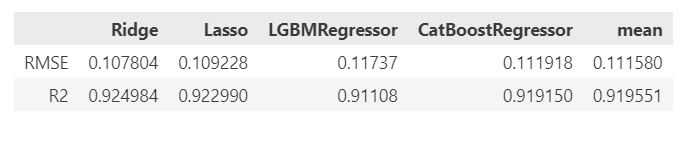

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145
R2	0.926683	0.926921	0.917358	0.926855	0.924454


**1. the result improved** Remove line Bath\
 #df_upd['Bath'] = 0.225 * df['BsmtFullBath'] + (-0.0121) * df['BsmtHalfBath'] + 0.636 * df['FullBath'] + 0.343 * df['HalfBath']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109357	0.118549	0.110127	**0.111468**\
R2	    0.924935	0.922807	0.909285	0.921716	0.919686\

2. Remove line
    #rem_id = [250, 314, 336, 496, 584, 935, 1299, 1329] **the result got worse**\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.121717	0.123135	0.145565	0.125641	0.129015\
R2		0.909447	0.907326	0.870488	0.903515	0.897694\


3.  Change filling GarageYrBlt with YearBuilt:**the result got worse**\
 df_upd['GarageYrBlt'] = df_upd['GarageYrBlt'].fillna(df_upd['YearBuilt']) #new_3 \
 	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108765	0.109870	0.119354	0.112227	0.112554\
R2		0.923641	0.922081	0.908048	0.918702	0.918118\

4. Round prediction to nearest 500 **the result got worse**\
pred = np.log1p(np.round(np.exp(pred) / 500) * 500)\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107754	0.109337	0.117429	0.111843	0.111591\
R2		0.925054	0.922835	0.910991	0.919257	0.919534\

**5. the result improved** Round prediction to nearest 100 \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107798	0.109229	0.117388	0.111896	**0.111578**\
R2		0.924993	0.922988	0.911053	0.919181	0.919554\

**6. the result improved** Changed order in OrdinalEncoder: \
oec = OrdinalEncoder(categories = [['Po', 'Fa', 'NA', 'TA', 'Gd', 'Ex']]) \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.108610	0.109345	0.117131	0.110971	**0.111514**\
R2		0.923858	0.922824	0.911442	0.920511	0.919659\

**7. the result improved** Added new feature Neighborhoodqual\
df_upd['Neighborhoodqual'] = df_upd.groupby('Neighborhood')['OverallQual'].transform('mean')\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.105718	0.106429	0.112291	0.106418	**0.107714**\
R2		0.927858	0.926885	0.918610	0.926900	0.925063\

**8. the result improved** Added new feature Totalarea\
df_upd['Totalarea'] = df_upd['GrLivArea'] + df_upd['LotArea']\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107839	0.109302	0.115733	0.109190	**0.110516**\
R2		0.924935	0.922885	0.913544	0.923043	0.921102\

8.2 	With normalization Totalarea shows worse results:
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean
RMSE	0.107930	0.109299	0.116401	0.111180	0.111202
R2		0.924808	0.922889	0.912543	0.920212	0.920113

9. Added new 'HasGarage', 'HasBasement', 'HasFireplace'. **the result doesnt improve**\
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.107306	0.108882	0.11737	0.112784	0.111586\
R2		0.925675	0.923476	0.91108	0.917893	0.919531\

10. Top for now 1+6+7+8  **Kaggle 0.13095 score**\

Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.106576	0.106403	0.113151	0.106451	0.108145\
R2		0.926683	0.926921	0.917358	0.926855	0.924454\

**11. Made changes in NormalizationTransformer() 

all results in the notebook are the same but **Kaggle 0.12924 score**\

**12. the result improved** Made changes in FillMissTransformer() regarding 'LotFrontage' and in FeatureEngineeringTransformer() regarding 'Neighborhoodqual'\
**Kaggle 0.12780 score**\
	Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.106516	0.106345	0.114100	0.104537	0.107874\
R2	0.926765	0.927001	0.915966	0.929462	0.924799

13. the result improved here, but got worse in Kaggle (0.12927) Changed order in OrdinalEncoder: \
oec = OrdinalEncoder(categories = [['Po', 'NA', 'Fa', 'TA', 'Gd', 'Ex']]) \
Ridge	Lasso	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.103994	0.106276	0.112607	0.105405	0.107070\
R2	0.930193	0.927096	0.918150	0.928285	0.925931
+ change alpha in ridge alg to 22

**14. the result improved** add Elastic Net\
Ridge	Lasso	ElasticNet	LGBMRegressor	CatBoostRegressor	mean\
RMSE	0.104397	0.106421	0.105142	0.111917	0.104537	0.106483\
R2	0.929651	0.926896	0.928643	0.919151	0.929462	0.926760

### Meta models

In [38]:
# # Stack

# model = XGBRegressor()

# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_all_stack_xgb.csv')

In [39]:
# # Stack
# model = LGBMRegressor(verbose=-1)

# # params_lgbm = {'n_estimators': [400, 1000],
# #         'learning_rate': [0.1],
# #         # 'colsample_bytree': [0.7, 0.8],
# #         'max_depth': [4, 8, 12],
# #         'num_leaves': [10, 50, 100, 150],
# #         'reg_alpha': [1.1, 1.2],
# #         'reg_lambda': [1.1, 1.2],
# #         'min_split_gain': [0.3, 0.4],
# #         'subsample': [0.8, 0.9],
# #         'subsample_freq': [10, 20]}

# # params_lgbm = {'learning_rate': [0.03, 0.05, 0.1],
# #                 "max_depth": [4, 8, 12],
# #                 "num_leaves": [100, 180], 
# #                 "max_bin": [200, 300],
# #                 'n_estimators': [250, 400]}

# params_lgbm = {'learning_rate': [0.03],
#                 "max_depth": [4],
#                 "num_leaves": [100], 
#                 "max_bin": [200],
#                 'n_estimators': [250]}


# gs_alg = GridSearchCV(model, param_grid = params_lgbm, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(models_train_pred, y_test)
# print(gs_alg.best_estimator_)

# fin_pred = gs_alg.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_cb_stack_lgb.csv')


In [40]:
# # Stack

# # params_cb = {'iterations': [100, 400, 600],
# #              'learning_rate': [0.03, 0.1],
# #             'depth': [4, 6, 10],
# #             'l2_leaf_reg': [1, 3, 5, 7, 9]}

# # model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE')
# # grid_search_result = model.grid_search(params_cb, X=models_train_pred, y=y_test, verbose=False)

# model = cb.CatBoostRegressor(verbose=False, loss_function='RMSE', depth=4, l2_leaf_reg=1, iterations=600, learning_rate=0.03)

# model.fit(models_train_pred, y_test)
# fin_pred = model.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_all_stack_cb.csv')

In [50]:
# Stack

model = LinearRegression()
model.fit(models_train_pred, y_test)
fin_pred = model.predict(models_test_pred)

# create submission file
subm = pd.DataFrame()
subm['Id'] = t_id.astype('int')
subm['SalePrice'] = np.expm1(fin_pred)
subm.set_index('Id').to_csv('subm_lm_cb_lg_rf_stack_lv.csv')


In [47]:
# # Stack

# model = SVR()

# # params_svr = {'C': [1, 4, 5, 6, 10, 20], #1, 5, 10,
# #             'degree': [1, 2, 3],
# #             'coef0': [0, 1, 2, 5, 10],
# #             'kernel': ["poly", "rbf", "sigmoid"]}

# params_svr = {'C': [5], 
#             'degree': [1],
#             'coef0': [10],
#             'kernel': ["poly"]}


# # gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg = GridSearchCV(model, param_grid = params_svr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)

# gs_alg.fit(models_train_pred, y_test)
# print(gs_alg.best_estimator_)

# fin_pred = gs_alg.predict(models_test_pred)

# # create submission file
# subm = pd.DataFrame()
# subm['Id'] = t_id.astype('int')
# subm['SalePrice'] = np.expm1(fin_pred)
# subm.set_index('Id').to_csv('submission_lm_cb_lg_stack_svr.csv')


In [48]:
models_train_pred

,Ridge,Lasso,LGBMRegressor,CatBoostRegressor
0,11.934819,11.939678,11.920598,11.937177
1,12.450833,12.441641,12.404889,12.383932
2,11.892991,11.895252,11.814219,11.874704
3,12.457855,12.454838,12.543105,12.557648
4,11.761162,11.748692,11.810785,11.850574
...,...,...,...,...
358,11.712552,11.716240,11.742744,11.725554
359,12.291606,12.295528,12.239966,12.290037
360,12.689567,12.710855,12.815534,12.825599
361,12.994728,12.999654,12.887641,12.964772


In [49]:
subm

,Id,SalePrice
0,1461,122537.613809
1,1462,162014.994262
2,1463,191801.506716
3,1464,202471.742574
4,1465,204991.253206
...,...,...
1454,2915,79075.862463
1455,2916,80010.870259
1456,2917,166652.986050
1457,2918,118079.880011


<Axes: xlabel='Ridge', ylabel='SalePrice'>

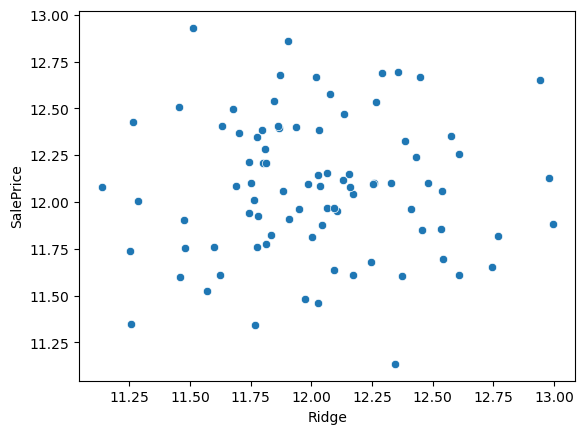

In [201]:
sns.scatterplot(x=models_train_pred['Ridge'], y=y_test)

<Axes: xlabel='Ridge', ylabel='1stFlrSF'>

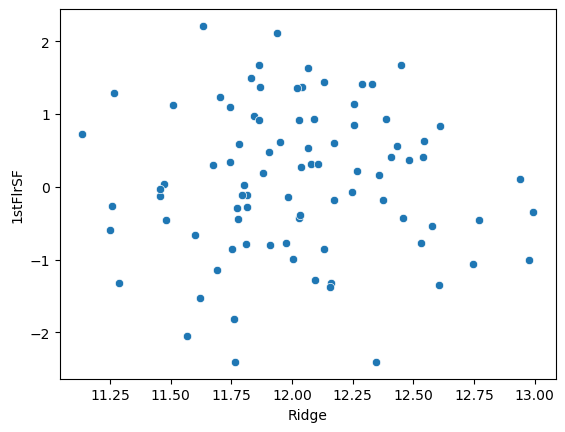

In [202]:
sns.scatterplot(x=models_train_pred['Ridge'], y=X_test['1stFlrSF'])

<Axes: xlabel='Ridge', ylabel='1stFlrSF'>

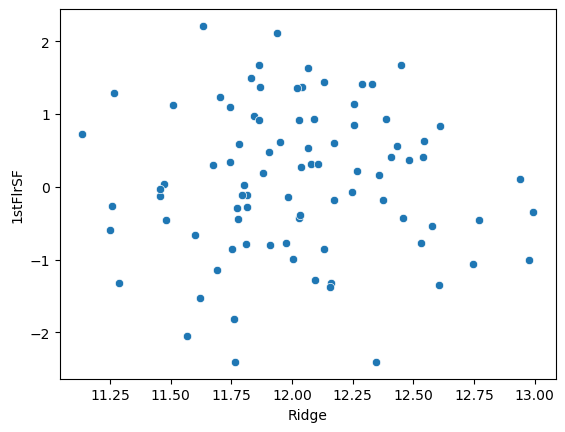

In [203]:
sns.scatterplot(x=models_train_pred['Ridge'], y=X_test['1stFlrSF'])

array([[<Axes: title={'center': 'Ridge'}>,
        <Axes: title={'center': 'Lasso'}>],
       [<Axes: title={'center': 'LGBMRegressor'}>,
        <Axes: title={'center': 'CatBoostRegressor'}>]], dtype=object)

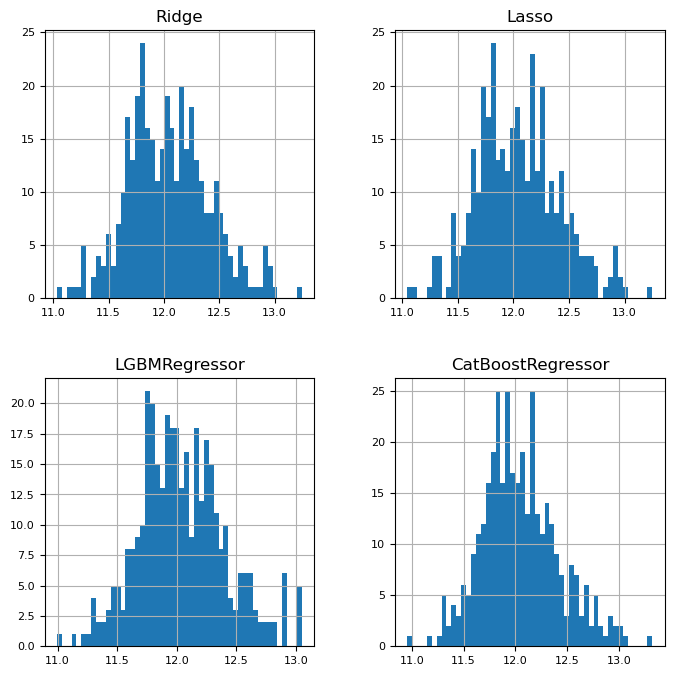

In [173]:
models_train_pred.hist(figsize=(8,8), bins=50, xlabelsize=8, ylabelsize=8)

<Axes: >

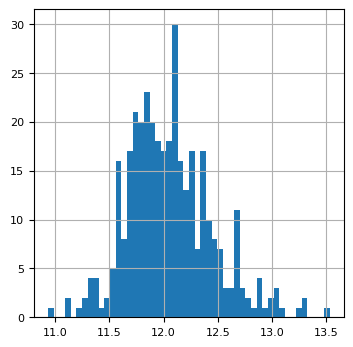

In [149]:
y_test.hist(figsize=(4,4), bins=50, xlabelsize=8, ylabelsize=8)

<Axes: xlabel='SalePrice', ylabel='1stFlrSF'>

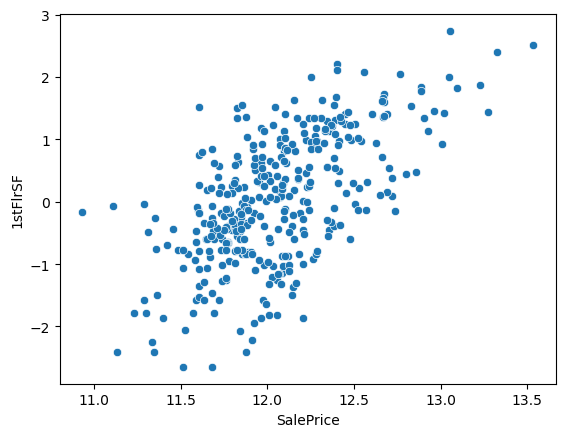

In [204]:
sns.scatterplot(x=y_test, y=X_test['1stFlrSF'])

<Axes: xlabel='Ridge', ylabel='SalePrice'>

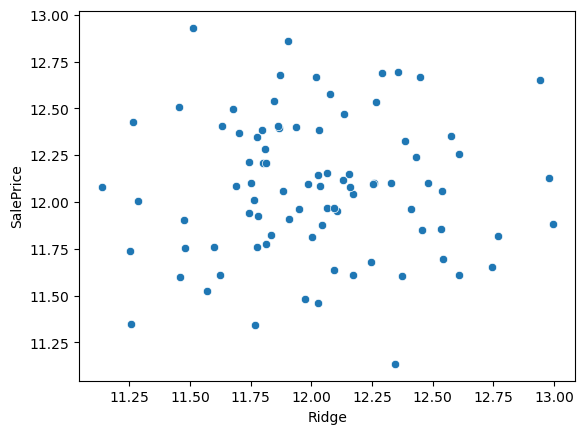

In [205]:
sns.scatterplot(x=models_train_pred['Ridge'], y=y_test)

<Axes: xlabel='SalePrice', ylabel='Totalarea'>

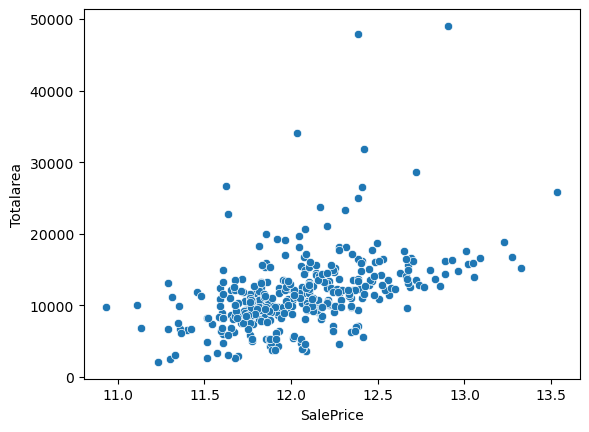

In [127]:
sns.scatterplot(x=y_test, y=X_test['Totalarea'])

<Axes: >

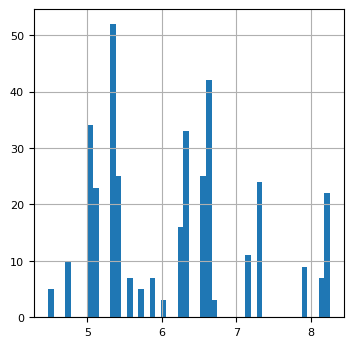

In [176]:
X_test['Neighborhoodqual'].hist(figsize=(4,4), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
sns.scatterplot(x=models_train_pred['Ridge'], y=y_test)

In [107]:
subm

,Id,SalePrice
0,1461,122786.981949
1,1462,162937.400647
2,1463,192331.603634
3,1464,203633.723101
4,1465,205013.674464
...,...,...
1454,2915,80358.860946
1455,2916,80726.555382
1456,2917,165123.964120
1457,2918,117801.348316


#### Linear models tests

Since linear models sensitive to correlation, we will remove features which have high correlation with each other. They are fixed in <b>col_tdrop_linm</b> 

What was tested:
<h5>1. - wo #1stFlrSF', '2ndFlrSF', <br>
- with MinMaxScaler()</h5><br>

1.1. <b>Lasso</b>(alpha=0.0, random_state=44) | grid search was {'alpha': np.arange(0.00, 1.0, 0.005), 'max_iter': [1000, 1200], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.124<br>
R2: 0.900 <br>
it doesn't converege<br>
kaggle: 0.15107<br>

1.2. <b>LassoCV</b><br>
return parametrs
{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}<br>
RMSE: 0.134<br>
R2: 0.884 <br>
kaggle - 

1.3. <b>Lasso</b>(alpha=0.001, max_iter=100, random_state=44) | grid search was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.112<br>
R2: 0.918 <br>
kaggle: <b>0.14718</b>

1.4. <b>RidgeCV</b><br>
Testing performance
{'alpha_per_target': False, 'alphas': (0.1, 1.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14996<br>

<h5>2. - with Power Transformer ()</h5><br>
2.1. <b>Lasso</b> (alpha=0.001, max_iter=100, random_state=44) | GS was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14174

2.2. <b>Ridge</b>(alpha=2.95, max_iter=1000, random_state=44) | GS was {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.109<br>
R2: 0.923 <br>
kaggle: 0.14072



<h5>3. <b>all features with Power Transformer ()</b></h5><br>
3.1. <b>Ridge</b>(alpha=2.95, max_iter=1000, random_state=44) | gs was {'alpha': np.arange(0.00, 3.0, 0.05), 'max_iter': [1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.110<br>
R2: 0.921 <br>
kaggle: <b>0.13981</b>

3.2. <b>Lasso</b>(alpha=0.001, max_iter=100, random_state=44) | gs was {'alpha': np.arange(0.001, 1.0, 0.002), 'max_iter': [100, 300, 1000, None], 'random_state': [rst]}<br>
Testing performance<br>
RMSE: 0.110<br>
R2: 0.921 <br>
kaggle: <b>0.14141 </b>

3.3. <b>Stack model</b> of 3.1 and 3.2<br>
LinearRegression<br>
kaggle: <b>0.13672</b><br>

3.4. <b>SVR</b>(C=10, coef0=10, degree=2, kernel='poly') | gs was {'C': [1, 5, 10, 24], 'degree': [1, 2, 3], 'coef0': [0, 5, 10], 'kernel': ["poly", "rbf", "sigmoid"]}<br>
Testing performance<br>
RMSE: 0.108<br>
R2: 0.924 <br>
kaggle 0.14329

3.5. <b>Stack model</b> of 3.1, 3.2 and 3.3 <br>
LinearRegression<br>
kaggle: <b>0.14156</b><br>

3.6. <b>Stack model</b> of 3.1, 3.2 with StandartScaler <br>
LinearRegression<br>
kaggle: <b>0.14045</b><br>